In [1]:
from numba import njit,jit
import seaborn as sns
sns.set(color_codes=True)
import matplotlib 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import scipy.stats as sp
import adsfunc as ads

273.15


In [2]:
%run data30min.py

data:
QC ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QI ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QSAT ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QV ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QVMPHY ('time', 'z', 'y', 'x') (48, 68, 128, 128)
W ('time', 'z', 'y', 'x') (48, 68, 128, 128)
p ('z',) (68,)
time ('time',) (48,)
x ('x',) (128,)
y ('y',) (128,)
z ('z',) (68,)


# Step 5: Taking into account atmospheric subsidence  

<img src="Figs/lastsaturationsubsidence.svg" width="700" height="450">

To make our model more realistic, we want to take into account the fact that air parcels move with finite speed through the environment. This speed is given by the atmospheric subsidence $w_{tot} = w_{env} + w_{ls}$. Suppose we have $N$ CRM simulations of atmospheric cloud states with corresponding times $t_i$, $i \in [1,N]$. Assuming those states are regularly separated by a time step $\Delta t$, the vertical distance covered by a moving parcel between two states will be   
$$
\Delta z = w_{tot}\Delta t
$$
We assume that $w_{tot}$ is negative, i.e. in the environment parcels have a downward velocity. Being interested by the last saturation altitude of an air parcel located in the troposphere ($z_{parcel}$ ~ 5km) at time $t_N$, we look for clouds in the interval $[z_{parcel}; z_{parcel} + \Delta z]$ at $t_N$, because this is the maximum distance the parcel can cover between $t_N$ and $t_{N-1}$.  

Now, let's assume no clouds are found at $t_N$ between $z_{parcel}$ and $z_{parcel} + \Delta z$. We can still find the altitude of last saturation of the parcel, by looking at earlier times. Every step backwards in time elevates the parcel by $\Delta z$ in the atmosphere. The distance covered between $t_{N-2}$ and $t_N$ is therefore $2\Delta z$. This can be generalised to find the maximum value of $z_{clouds}$ (altitude above the parcel) as a function of atmospheric cloud state $i$
$$
\Delta z_i = (N-i+1) w_{tot}\Delta t
$$
We could therefore find our new $z_{clouds}$ by making minor tweaks to our previous method. The process could be to compute all the lowest altitudes of clouds above $z_{parcel}$ = 5 km for an increasing range of $z$ values as we go back in time. For example, at $t_N$ we could only search in the range $[z_{parcel}; z_{parcel} + \Delta z]$, at $t_{N-1}$ in the range $[z_{parcel}; z_{parcel} + 2\Delta z]$, etc.. Then, the actual $z_{clouds}$ corresponding to the last saturation would be found by taking the lowest altitudes of clouds above the parcel at the highest $i$.

**Potential problems with this apporach**  

<img src="Figs/problems.svg" width="500" height="400"> 

Setting $\Delta t$ small enough should solve these issues in two ways:  
- It prevents the parcel from travelling large distances between $t_i$ and $t_{i+1}$ and miss some cloudy regions  
- It makes the clouds move slow enough so that from one $t_i$ to the next, cloudy regions cannot appear between the different parcel altitudes at $t_i$ and $t_{i+1}$

## Calculation of $w_{tot}$  

We are provided with vertical velocity $w$ at every coordinate, and are interested in the velocity of parcels outside clouds. Some simulations have an additional vertical velocity component $w{LS}$ which represent a large scale updraft. For simulations with no updraft, $w_{LS} = 0$ everywhere therefore the total vertical velocity outside convection is 
$$
w_{tot} = w_{env} + w_{LS}
$$

We first need to calculate $w_{env}$, which is the subsidence speed in the environment. To simplify future calculations we might want to take this as a constant over the domain and so average it over the whole grid instead of assigning one $w_{env}$ value to each grid point. Thus, we can compute 
$$
\bar{w}_{env} = \left.\bar{w}\right|_{q_i+q_c<10^{-6}}
$$
which is the mean vertical speed of air outside clouds.

*Getting the data*

In [3]:
print(data.variables['W'])

<class 'netCDF4._netCDF4.Variable'>
float32 W(time, z, y, x)
    long_name: Z Wind Component                                                                
    units: m/s       
unlimited dimensions: time
current shape = (48, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used
<ipython-input-3-175fce97c65e>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(data.variables['W'])


The function $\texttt{MWENV}$ computes the sum of mixing ratios $q_c$ and $q_i$ at every grid point and time step. It then appends the value of $w$ at this coordinate if the grid point is not in a cloud $(q_c + q_i < 1 \times 10^{-6})$. If the grid point is in a cloud, the value appended is a $\texttt{NaN}$. We then compute $\bar{w}_{env}$ by averaging $w_{env}$ over all non-$\texttt{NaN}$ values.

In [4]:
mwenv = np.nanmean(ads.MWENV(t,x,y,z,w,qc,qi), axis=(0,2,3))
mwenv2 = np.nanmean(ads.MWENV(t2,x2,y2,z2,w2,qc2,qi2), axis=(0,2,3))
mwenv3 = np.nanmean(ads.MWENV(t3,x3,y3,z3,w3,qc3,qi3), axis=(0,2,3))
mwenv4 = np.nanmean(ads.MWENV(t4,x4,y4,z4,w4,qc4,qi4), axis=(0,2,3))
mwenv5 = np.nanmean(ads.MWENV(t5,x5,y5,z5,w5,qc5,qi5), axis=(0,2,3))
mwenv6 = np.nanmean(ads.MWENV(t6,x6,y6,z6,w6,qc6,qi6), axis=(0,2,3))
mwenv7 = np.nanmean(ads.MWENV(t7,x7,y7,z7,w7,qc7,qi7), axis=(0,2,3))
mwenv8 = np.nanmean(ads.MWENV(t8,x8,y8,z8,w8,qc8,qi8), axis=(0,2,3))
mwenv9 = np.nanmean(ads.MWENV(t9,x9,y9,z9,w9,qc9,qi9), axis=(0,2,3))
mwenv10 = np.nanmean(ads.MWENV(t10,x10,y10,z10,w10,qc10,qi10), axis=(0,2,3))

mwenvlist = [mwenv, mwenv2, mwenv3, mwenv4, mwenv5, mwenv6, mwenv7, mwenv8, mwenv9, mwenv10]

We find a $\bar{w}_{env}$ for each simulation. The three experiments without atmospheric ascendance have $\bar{w}_{env}$ superior to their counterparts. This means that the average downward speed in the environment is higher when there is ascendance.

In [5]:
interval = np.linspace(0, 1, len(mwenvlist))
colorlist = [mpl.cm.rainbow(i) for i in interval]
labelslist = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

zlist = []
zlist.append(z)
for i in np.arange(2,11):
    zlist.append(locals()['z'+str(i)])

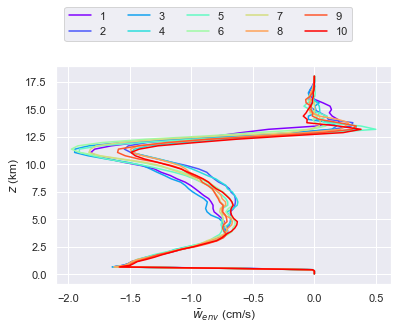

In [6]:
for i in np.arange(len(mwenvlist)):
    plt.plot(mwenvlist[i][0:72]*100, zlist[i][0:72]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\bar{w}_{env}$ (cm/s)')
plt.ylabel('$z$ (km)')
plt.legend(bbox_to_anchor=(0.9, 1.3), ncol=5)
plt.savefig('Figs2/wenvz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

As stated previously the total velocity of a parcel moving in the environment is not $\bar{w}_{env}$ for every simulations, because half of them have an imposed large scale velocity $w_{LS}$ at every $z$. To accurately compute the velocity of a parcel moving outside convective clouds we need to compute 
$$
\bar{w}_{tot} = \bar{w}_{env} + w_{LS}
$$
where the bars denote an average over the horizontal grid points. Note that $w_{LS}$ is already defined to be horizontally constant.

The calculation of $w_{LS}$ was made using a prewritten .f90 file that was translated by hand to python. A $\texttt{.h}$ file containing useful physical constants has also been translated and is used in the following cell.

In [7]:
# %run const_thermo.py

# SST = 30
# pp = 1000
# pvzero = 100
# H = 10
pmax = 500

Here we pull data from the .netCDF file yet again to get the pressure as a function of altitude $\texttt{p(z)}$. Where easily doable, parameters where defined using loops.

### Translation of fortran function for $w_{ls}$

Below we use the same looping process to generate the 6 $w_{LS}$ from the function.

In [8]:
wLSlist = []
wLS = ads.WLS(nz,p,pmax,omegamax)[0]
wLSlist.append(wLS)
for i in np.arange(2,11):
    locals()["wLS"+str(i)] = ads.WLS(nzlist[i-1],plist[i-1],pmax,omegamaxlist[i-1])[0]
    wLSlist.append(locals()["wLS"+str(i)])
wLSlist = np.asarray(wLSlist)

As the imposed large scale vertical updraft was the same for affected simulations, we only plot 2 cases: one with the large scale updraft and one without

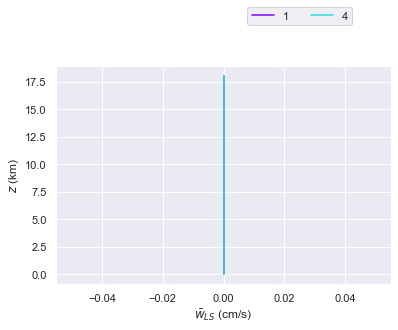

In [9]:
for i in np.arange(4,step=3):
    plt.plot(wLSlist[i]*100, zlist[i]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\bar{w}_{LS}$ (cm/s)')
plt.ylabel('$z$ (km)')
plt.legend(bbox_to_anchor=(0.9, 1.3), ncol=2)
plt.savefig('Figs/wLSz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

$\bar{w}_{tot}$ can now be computed for every simulation. Note that $\bar{w}_{tot} = \bar{w}_{env}$ for simulations without large scale updraft.

In [10]:
wtot = ads.WTOT(mwenv, wLS)
wtot2 = ads.WTOT(mwenv2, wLS2)
wtot3 = ads.WTOT(mwenv3, wLS3)
wtot4 = ads.WTOT(mwenv4, wLS4)
wtot5 = ads.WTOT(mwenv5, wLS5)
wtot6 = ads.WTOT(mwenv6, wLS6)
wtot7 = ads.WTOT(mwenv7, wLS7)
wtot8 = ads.WTOT(mwenv8, wLS8)
wtot9 = ads.WTOT(mwenv9, wLS9)

wtotlist = [wtot, wtot2, wtot3, wtot4, wtot5, wtot6, wtot7, wtot8, wtot9]

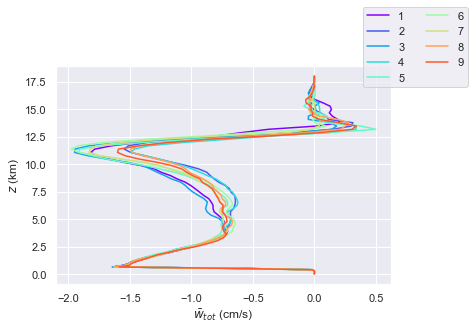

In [12]:
for i in np.arange(len(wtotlist)):
    plt.plot(wtotlist[i]*100, zlist[i]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\bar{w}_{tot}$ (cm/s)')
plt.ylabel('$z$ (km)')
plt.legend(bbox_to_anchor=(0.9, 1.3), ncol=2)
plt.savefig('Figs/wtotz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

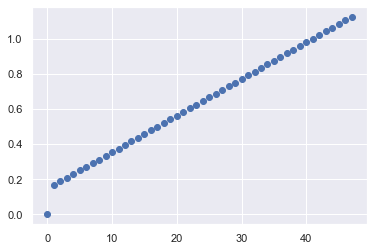

In [11]:
t = data.variables['time'][:]
t += -23
plt.scatter(np.arange(len(t)), t)
plt.show()
deltat = np.zeros(t.shape)
for time in np.arange(1,len(t)):
    deltat[time] = t[time] - t[time-1]

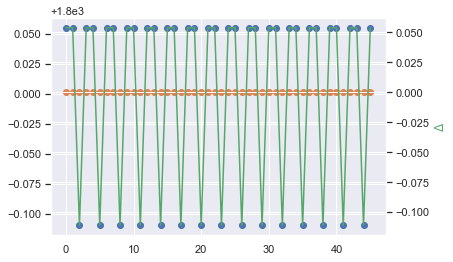

In [12]:
conv = 24*60**2             # days to seconds
deltat = deltat*conv
deltat2 = np.zeros(deltat.shape)
deltat2[2:] = np.mean(deltat[2:])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(np.arange(len(deltat)-2), deltat[2:])
ax1.scatter(np.arange(len(deltat)-2), deltat2[2:])
ax2.plot(np.arange(len(deltat)-2), deltat[2:]-deltat2[2:], color = 'g')
ax2.set_ylabel('$\Delta$', color='g')
plt.show()

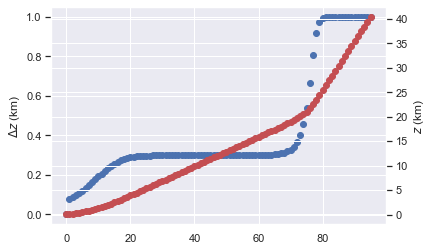

In [13]:
deltaz = np.zeros(len(z))
for k in np.arange(1,len(z)):
    deltaz[k] = z[k] - z[k-1]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(np.arange(len(deltaz)), deltaz/1000)
ax1.set_ylabel('$\Delta z$ (km)')
ax2.scatter(np.arange(len(z)), z/1000, color = 'r')
ax2.set_ylabel('$z$ (km)')
plt.show()

In [14]:
izparcel = ads.Zparcel(z)[0]
dzp = 0
i = 0
while dzp < deltaz[i+1]:
    dzp += -mwenv[izparcel] * deltat[i]
    if i>=len(t)-1:
        break
    else:
        i += 1
print('dzp = ', dzp, 'mwenv[izparcel] = ', mwenv[izparcel], 'i = ',i)

dzp =  109.4810722953092 mwenv[izparcel] =  -0.007602881245420104 i =  2


In [155]:
deltaz[1]

79.21800231933594

In [22]:
@njit
def LSADYN(T, X, Y, Z, QI, QC, QSAT):
    zclouds = np.zeros((len(T), len(X), len(Y)))
    izclouds = np.zeros((len(T), len(X), len(Y)))
    qsatzclouds = np.zeros((len(T), len(X), len(Y)))
    thresh = 1e-6
    for time in np.arange(len(T)):
        for i in np.arange(len(X)):
            for j in np.arange(len(Y)):
                cond = QC[time, adsfunc.Zparcel(Z)[0]:, j, i] + QI[time, adsfunc.Zparcel(Z)[0]:, j, i]
                if np.max(cond) - thresh >= 0:
                    toto = np.where(cond-thresh >= 0)
                    (matrix,) = toto
                    zclouds[time, i, j] = Z[ads.Zparcel(Z)[0]+np.min(matrix)]
                    izclouds[time, i, j] = int(ads.Zparcel(Z)[0]+np.min(matrix))
                    qsatzclouds[time, i, j] = QSAT[time,ads.Zparcel(Z)[0]+np.min(matrix), j, i]
                    if qsatzclouds[time, i, j] > 100:
                        qsatzclouds[time, i, j] = qsatzclouds[time, i, j]/1000
                else:
                    zclouds[time, i, j] = np.max(Z)
                    izclouds[time, i, j] = int(np.argmax(Z))
                    qsatzclouds[time, i, j] = QSAT[time, np.argmax(Z), j, i]
                    if qsatzclouds[time, i, j] > 100:
                        qsatzclouds[time, i, j] = qsatzclouds[time, i, j]/1000
    return zclouds, izclouds, qsatzclouds

In [ ]:
-